# 2020 TO 2023 US Congress members' stock transactions analysis

## Table of Contents
- [Introduction and Posing Questions](#intro)
- [Data Collection and Wrangling](#wrangle)
- [Exploratory Data Analysis](#eda)
   - [Statistics](#stats)
   - [Visualizations](#visuals)

<a id="intro"></a>
## Introduction and Posing Questions

In this project, I will perform exploratory data analysis on the data provided by [House Stock Watcher](https://housestockwatcher.com/api) on the US Congress members' stock transactions for the years 2020, 2021, 2022, and 2023. The dataset includes various columns providing information on disclosure dates, transaction dates, asset details, transaction types, amounts, and other relevant attributes.
I seek to uncover patterns, trends, and potential conflicts of interest within the data. As a result, I have developed thought-provoking questions that can guide my analysis and uncover meaningful insights:

1. What are the primary motivations driving Congress members' stock transactions?
   - How do demographic factors such as party affiliation, and state influence trading activities?
   - Are there noticeable patterns in trading behavior based on transaction types such as purchases or sales?
   - Can we identify any correlation such as transaction amount and party affiliations?  
2. Are there observable trends in the frequency and volumes of stock transactions over multiple years?
   - Do certain years exhibit higher trading activities among Congress members, and if so, what factors might contribute to these fluctuations?
   - How does transaction volume vary across different sectors and industries, are there sectors that Congress members show a particular interest in?
   - Can we identify any anomalies or spikes in trading activities that warrant further investigation? 
3. Can we analyze the performance of Congress members' stock portfolios and identify any notable trends?
   - How do capital gain from stock transactions vary across different party affiliations?
   - Are there sectors that Congress members consistently realize higher capital gains, and what factors might explain these trends?
4. How can we cross-analyze trends between data dimensions to uncover deeper insights?
   - Are there correlations between transaction frequencies and demographic factors such as party affiliations or district representation?
   - How do sector-specific trends in stock transactions correlate with party affiliations?
   - Can we identify any systematic biases or patterns in trading activities that warrant further investigations?
     

<a id="wrangle"></a>
## Data Collection and Wrangling

The data utilized in this project is sourced from [House Stock Watcher](https://housestockwatcher.com), offering comprehensive stock transaction information of US Congress members spanning the years 2020 to 2023. Accessible via [House Stock Watcher API](https://house-stock-watcher-data.s3-us-west-2.amazonaws.com/data/all_transactions.json), this data is conveniently available in JSON format, facilitating integration and analysis.

In [1]:
## Import the necessary packages
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Style

In [2]:
## Get the data from the API and change it into Pandas DataFrame
api_url = "https://house-stock-watcher-data.s3-us-west-2.amazonaws.com/data/all_transactions.json"
response = requests.get(api_url)
data = response.json()
df = pd.DataFrame(data)
df.head(3)

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,state,ptr_link,cap_gains_over_200_usd,industry,sector,party
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,NC,https://disclosures-clerk.house.gov/public_dis...,False,Integrated oil Companies,Energy,Republican
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,NC,https://disclosures-clerk.house.gov/public_dis...,False,Integrated oil Companies,Energy,Republican
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,NC,https://disclosures-clerk.house.gov/public_dis...,False,Real Estate Investment Trusts,Real Estate,Republican


Now that we have the data loaded, it's observable from the above printout that the column formats are different even where the information is the same e.g. the date columns; `disclosure_date` and `transaction_date`. We will trim and clean the data to make things as simple as possible when we get to the actual exploration. Cleaning the data makes sure that the data formats are consistent while trimming focuses only on the part of the data we are interested in to make the exploration easier to work with.

In [3]:
# Select the columns relevant to the analysis
columns_to_drop = ["ticker","asset_description", "ptr_link", "district","cap_gains_over_200_usd"]
stocks = df.drop(columns = columns_to_drop)
# Identify the indexes of the rows containing the problematic dates and drop them
index1 = stocks[stocks["transaction_date"] == "0009-06-09"].index
index2 = stocks[stocks["transaction_date"] == "0022-11-23"].index
index3 = stocks[stocks["transaction_date"] == "0021-08-02"].index
index4 = stocks[stocks["transaction_date"] == "0222-11-22"].index
index5 = stocks[stocks["transaction_date"] == "0023-01-11"].index
index6 = stocks[stocks["transaction_date"] == "0021-06-22"].index
index7 = stocks[stocks["transaction_date"] == "0201-06-22"].index
index8 = stocks[stocks["transaction_date"] == "0222-11-02"].index
problematic_indexes = list(index1) + list(index2) + list(index3) + list(index4) + list(index5) + list(index6) + list(index7) + list(index8)
stocks.drop(problematic_indexes, inplace = True)
# Replace the incorrect dates with correct ones using .loc
stocks.loc[stocks["transaction_date"] == "20222-08-09", "transaction_date"] = "2022-08-09"
stocks.loc[stocks["transaction_date"] == "20222-07-18", "transaction_date"] = "2022-07-18"
stocks.loc[stocks["transaction_date"] == "20222-11-16", "transaction_date"] = "2022-11-16"
stocks.loc[stocks["transaction_date"] == "20221-11-18", "transaction_date"] = "2021-11-18"
# Convert date columns to DateTime data type with specified formats
stocks["disclosure_date"] = pd.to_datetime(stocks["disclosure_date"], format = "%m/%d/%Y")
stocks["transaction_date"] = pd.to_datetime(stocks["transaction_date"], format = "%Y-%m-%d")
stocks.head(3)

,disclosure_year,disclosure_date,transaction_date,owner,type,amount,representative,state,industry,sector,party
0,2021,2021-10-04,2021-09-27,joint,purchase,"$1,001 - $15,000",Virginia Foxx,NC,Integrated oil Companies,Energy,Republican
1,2021,2021-10-04,2021-09-13,joint,purchase,"$1,001 - $15,000",Virginia Foxx,NC,Integrated oil Companies,Energy,Republican
2,2021,2021-10-04,2021-09-10,joint,purchase,"$15,001 - $50,000",Virginia Foxx,NC,Real Estate Investment Trusts,Real Estate,Republican


<a id="eda"></a>
## Exploratory Data Analysis

Now that we have the data wrangled, we're ready to start exploring the data. In this section, I will dive deep into our dataset to uncover patterns, trends, anomalies, and relationships that will provide valuable insights into our data. 
To begin the exploration, I will compute some descriptive statistics from the data, and then move into visualizations.

<a id="stats"></a>
### Statistics

First, let's compute some basic statistics from the data.

In [4]:
def compute_descriptive_statistics(df):
    # Total number of transactions
    total_transactions = len(df)

    # Representative with the highest number of transactions
    highest_transaction_rep = df['representative'].value_counts().idxmax()
    highest_transaction_count = df['representative'].value_counts().max()

    # Party with the highest number of transactions
    highest_transaction_party = df['party'].value_counts().idxmax()
    highest_transaction_party_count = df['party'].value_counts().max()

    # Most common transaction amount
    most_common_amount = df['amount'].mode()[0]
    most_common_amount_count = df['amount'].value_counts().max()

    # Most common sector
    most_common_sector = df['sector'].mode()[0]
    # Most common industry
    most_common_industry = df['industry'].mode()[0]
    # Most common transaction type
    most_common_transaction_type = df['type'].mode()[0]
    # Most common owner
    most_common_owner = df['owner'].mode()[0]
    # Most common state
    most_common_state = df['state'].mode()[0]
    # Number of stock transactions by year
    transactions_by_year = df['disclosure_year'].value_counts().to_dict()

    print("Findings:")
    print(Fore.GREEN + f"Total number of transactions: " + Fore.RED + f"{total_transactions}")
    print(Fore.GREEN + f"Representative with the highest number of transactions: " + Fore.RED +
          f"{highest_transaction_rep} ({highest_transaction_count} transactions)")
    print(Fore.GREEN + f"Party with the highest number of transactions: " + Fore.RED +
          f"{highest_transaction_party} ({highest_transaction_party_count} transactions)")
    print(Fore.GREEN + f"Most common transaction amount: " + Fore.RED +
          f"{most_common_amount} ({most_common_amount_count} transactions)")
    print(Fore.GREEN + f"Sector with the most transactions: " + Fore.RED + f"{most_common_sector}")
    print(Fore.GREEN + f"Industry with the most transactions: " + Fore.RED + f"{most_common_industry}")
    print(Fore.GREEN + f"Most common transaction type: " + Fore.RED + f"{most_common_transaction_type}")
    print(Fore.GREEN + f"Owner accounts that transacted most: " + Fore.RED + f"{most_common_owner}")
    print(Fore.GREEN + f"State with most transactions: " + Fore.RED + f"{most_common_state}")
    print(Fore.GREEN + "\nNumber of Stock Transactions by Year:")
    for year, count in transactions_by_year.items():
        print(Fore.RED + f"{year}: {count}")

# Run the function on the US Congress stock transactions dataset
compute_descriptive_statistics(stocks)


Findings:
Total number of transactions: 17162
Representative with the highest number of transactions: Josh Gottheimer (1453 transactions)
Party with the highest number of transactions: Democrat (10500 transactions)
Most common transaction amount: $1,001 - $15,000 (12079 transactions)
Sector with the most transactions: Technology
Industry with the most transactions: Computer Software: Prepackaged Software
Most common transaction type: purchase
Owner accounts that transacted most: joint
State with most transactions: CA

Number of Stock Transactions by Year:
2020: 7379
2021: 5516
2022: 3354
2023: 913


<a id="visuals"></a>
### Visualizations

I will further explore the US Congress members' stock data using visualizations created with Matplotlib and Seaborn libraries. I aim to gain deeper insights into the stock transaction and understand the patterns and trends from the period 2020 to 2023.

**1. Distribution of Transaction Amounts**

Let's start by visualizing the distribution of transaction amounts to understand the range and frequency of transactions:

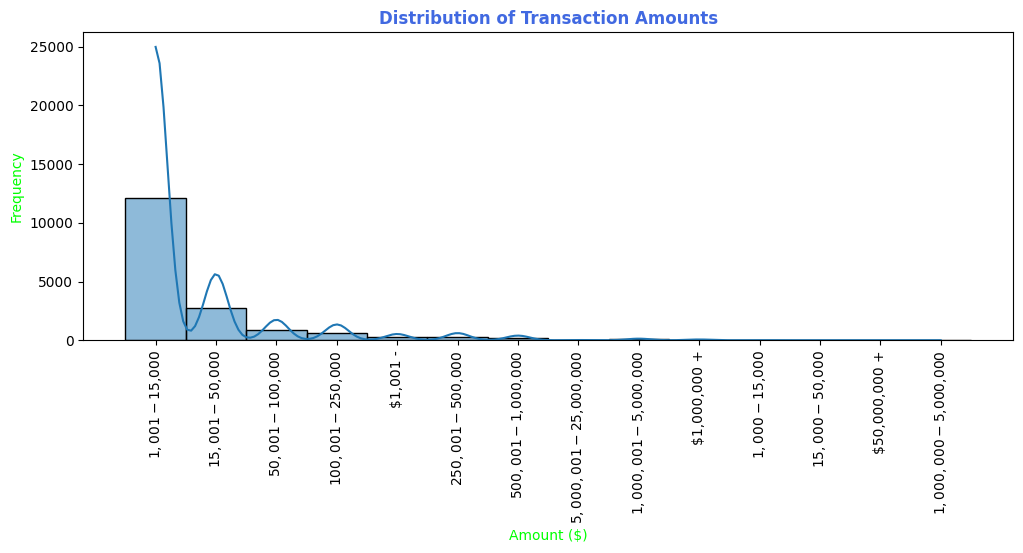

In [5]:
plt.figure(figsize=(12, 4))
sns.histplot(stocks['amount'], kde=True)
plt.title('Distribution of Transaction Amounts', color = 'royalblue', weight = 'bold')
plt.xlabel('Amount ($)', color = 'lime')
plt.ylabel('Frequency', color = 'lime')
plt.xticks(rotation=90)
plt.show()

The Histogram above shows that most of the US Congress members' stock transaction amounts were in the range of $1000-$15000. This aligns with our calculation above where we found that 12079 transactions out of 17162 were in this range.
The above plot has a kernel density estimate(KDE) which provides a smoothened representation of the underlying distribution of the transaction amounts. The data shape is right-skewed, indicating that most US Congress members' transactions have lower amounts, with a few transactions having higher amounts.

**2. Distribution of transaction amounts by Party Affiliations**

Let's now visualize the distribution of transaction amounts by party affiliations to see if there are any differences in trading behaviours among different political parties:

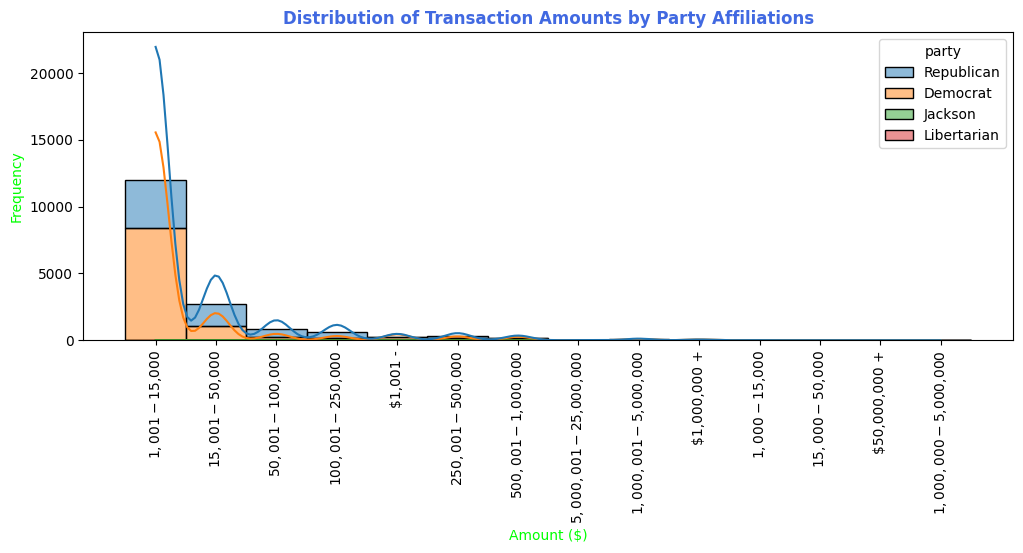

In [6]:
plt.figure(figsize=(12, 4))
sns.histplot(data=stocks, x='amount', hue='party', kde=True, multiple='stack')
plt.title('Distribution of Transaction Amounts by Party Affiliations', color='royalblue', weight='bold')
plt.xlabel('Amount ($)', color='lime')
plt.ylabel('Frequency', color='lime')
plt.xticks(rotation=90)
plt.show()

The plot above shows that most transactions were carried out by Democrats, which aligns with our calculations from above where the Democrats had 10500 transactions. However, as the transaction amount increases, we see slightly more transactions by the Republicans.

**3. Distribution of transactions across different sectors**

Here, I will explore the distribution of transactions across different sectors to identify which sectors are most frequently involved in stock transactions by Congress members.

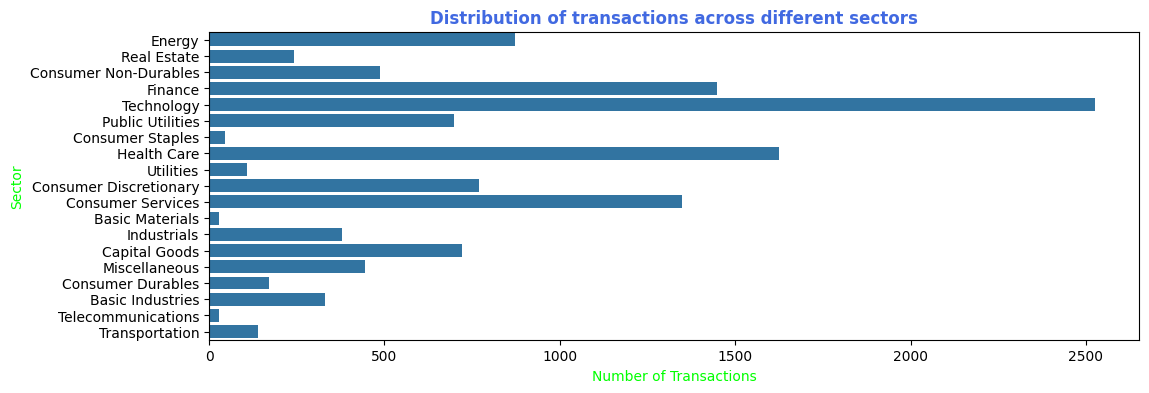

In [7]:
plt.figure(figsize=(12, 4))
sns.countplot(data=stocks, y='sector')
plt.title('Distribution of transactions across different sectors', color='royalblue', weight='bold')
plt.xlabel('Number of Transactions', color='lime')
plt.ylabel('Sector', color='lime')
plt.show()

From the above plot, we can see that the Technology sector had the most stocks transactions by the Congress members. Other sectors like Health Care, Finance, Consumer Services and Energy had higher transactions while sectors like Telecommunications, Basic Materials, and Consumer Staples had the least transactions.